## Iceberg retrieval fig

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json

from ms_pred import common
from ms_pred.common import plot_utils
from ms_pred.common.plot_utils import *
from scipy.stats import sem

from collections import defaultdict

set_style()
%load_ext autoreload
%autoreload 2

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_names = ["nist20", "canopus_train_public"]
results_folder = Path("../results/figs_iceberg/retrieval")
results_folder.mkdir(exist_ok=True)

In [3]:
names = [
    "Random",
    "3DMolMS",
    "FixedVocab",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "MassFormer",
    "SCARF",
    "ICEBERG"
]

dataset_to_res = {}
for dataset_name in dataset_names:
    yaml_files = defaultdict(lambda : [])
    for seed in [1,2,3]:    
        results_files = [
            f"../results/dag_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_random.yaml",
            f"../results/molnetms_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/graff_ms_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/ffn_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/gnn_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/massformer_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/scarf_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
             f"../results/dag_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        ]


        for i, j in zip(names, results_files):
            yaml_files[i].append(yaml.safe_load(open(j, "r")))
    dataset_to_res[dataset_name] = yaml_files

In [4]:
out_df = []
keys_to_name = {f"avg_top_{i}": i for i in range(1, 11)}

for dataset, yaml_files in dataset_to_res.items():

    for k, v in yaml_files.items():
        for old_name, new_name in keys_to_name.items():
            new_entry = {
                "Method": k,
                "Top k": new_name,
                "Acc mean": np.mean([vv[old_name] for vv in v]),
                "Acc 95%": 1.96 * sem([vv[old_name] for vv in v]),
                "Dataset": dataset,
            }
            new_entry['Acc'] = rf"${new_entry['Acc mean']: .3f} \pm {new_entry['Acc 95%']:.3f}$"
            out_df.append(new_entry)
out_df = pd.DataFrame(out_df)

In [5]:
for dataset_name in dataset_names:
    # Filter out df to specific dataset
    df = out_df[out_df["Dataset"] == dataset_name]
    pivoted_tbl = df.reset_index().pivot_table(
        index="Method", values="Acc", columns="Top k", aggfunc="first"
    )
    pivoted_tbl.index.name = None
    pivoted_tbl = pivoted_tbl.round(3)
    pivoted_tbl = pivoted_tbl.loc[names]


    # Get only k in [1,2,3,4,5,8,10]
    pivoted_tbl = pivoted_tbl[[1,2,3,4,5,8,10]]

    latex = pivoted_tbl.to_latex(
        caption=f"{dataset_name} spectra prediction retrieval accuracy",
        label=f"tab:{dataset_name}_spec_retrieval",
        escape=False,
    )
    display(pivoted_tbl)
    print(latex)
    # Save
    with open(results_folder / f"retrieval_{dataset_name}.txt", "w") as f:
        f.write(latex)

/tmp/ipykernel_3154012/1516827397.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


Top k,1,2,3,4,5,8,10
Random,$ 0.026 \pm 0.001$,$ 0.052 \pm 0.001$,$ 0.076 \pm 0.002$,$ 0.098 \pm 0.001$,$ 0.120 \pm 0.001$,$ 0.189 \pm 0.003$,$ 0.233 \pm 0.004$
3DMolMS,$ 0.055 \pm 0.003$,$ 0.105 \pm 0.000$,$ 0.146 \pm 0.005$,$ 0.185 \pm 0.007$,$ 0.225 \pm 0.009$,$ 0.332 \pm 0.005$,$ 0.394 \pm 0.008$
FixedVocab,$ 0.172 \pm 0.004$,$ 0.304 \pm 0.004$,$ 0.399 \pm 0.002$,$ 0.466 \pm 0.007$,$ 0.522 \pm 0.012$,$ 0.638 \pm 0.009$,$ 0.688 \pm 0.006$
NEIMS (FFN),$ 0.105 \pm 0.003$,$ 0.243 \pm 0.012$,$ 0.324 \pm 0.013$,$ 0.387 \pm 0.011$,$ 0.440 \pm 0.014$,$ 0.549 \pm 0.010$,$ 0.607 \pm 0.005$
NEIMS (GNN),$ 0.175 \pm 0.005$,$ 0.305 \pm 0.003$,$ 0.398 \pm 0.002$,$ 0.462 \pm 0.004$,$ 0.515 \pm 0.005$,$ 0.632 \pm 0.007$,$ 0.687 \pm 0.005$
MassFormer,$ 0.191 \pm 0.008$,$ 0.328 \pm 0.006$,$ 0.422 \pm 0.003$,$ 0.491 \pm 0.002$,$ 0.550 \pm 0.005$,$ 0.662 \pm 0.005$,$ 0.716 \pm 0.003$
SCARF,$ 0.187 \pm 0.008$,$ 0.321 \pm 0.011$,$ 0.417 \pm 0.007$,$ 0.486 \pm 0.008$,$ 0.541 \pm 0.009$,$ 0.652 \pm 0.008$,$ 0.708 \pm 0.009$
ICEBERG,$ 0.189 \pm 0.012$,$ 0.375 \pm 0.005$,$ 0.489 \pm 0.007$,$ 0.567 \pm 0.005$,$ 0.623 \pm 0.004$,$ 0.725 \pm 0.003$,$ 0.770 \pm 0.002$


\begin{table}
\centering
\caption{nist20 spectra prediction retrieval accuracy}
\label{tab:nist20_spec_retrieval}
\begin{tabular}{llllllll}
\toprule
Top k &                  1  &                  2  &                  3  &                  4  &                  5  &                  8  &                  10 \\
\midrule
Random      &  $ 0.026 \pm 0.001$ &  $ 0.052 \pm 0.001$ &  $ 0.076 \pm 0.002$ &  $ 0.098 \pm 0.001$ &  $ 0.120 \pm 0.001$ &  $ 0.189 \pm 0.003$ &  $ 0.233 \pm 0.004$ \\
3DMolMS     &  $ 0.055 \pm 0.003$ &  $ 0.105 \pm 0.000$ &  $ 0.146 \pm 0.005$ &  $ 0.185 \pm 0.007$ &  $ 0.225 \pm 0.009$ &  $ 0.332 \pm 0.005$ &  $ 0.394 \pm 0.008$ \\
FixedVocab  &  $ 0.172 \pm 0.004$ &  $ 0.304 \pm 0.004$ &  $ 0.399 \pm 0.002$ &  $ 0.466 \pm 0.007$ &  $ 0.522 \pm 0.012$ &  $ 0.638 \pm 0.009$ &  $ 0.688 \pm 0.006$ \\
NEIMS (FFN) &  $ 0.105 \pm 0.003$ &  $ 0.243 \pm 0.012$ &  $ 0.324 \pm 0.013$ &  $ 0.387 \pm 0.011$ &  $ 0.440 \pm 0.014$ &  $ 0.549 \pm 0.010$ &  $ 0.607 \pm 0.005$ \\
NEI

/tmp/ipykernel_3154012/1516827397.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


Top k,1,2,3,4,5,8,10
Random,$ 0.033 \pm 0.002$,$ 0.061 \pm 0.010$,$ 0.092 \pm 0.007$,$ 0.118 \pm 0.005$,$ 0.141 \pm 0.012$,$ 0.216 \pm 0.012$,$ 0.258 \pm 0.012$
3DMolMS,$ 0.087 \pm 0.003$,$ 0.159 \pm 0.020$,$ 0.218 \pm 0.008$,$ 0.268 \pm 0.012$,$ 0.317 \pm 0.011$,$ 0.427 \pm 0.016$,$ 0.488 \pm 0.010$
FixedVocab,$ 0.193 \pm 0.007$,$ 0.314 \pm 0.008$,$ 0.390 \pm 0.005$,$ 0.448 \pm 0.010$,$ 0.492 \pm 0.003$,$ 0.587 \pm 0.010$,$ 0.635 \pm 0.011$
NEIMS (FFN),$ 0.195 \pm 0.005$,$ 0.313 \pm 0.005$,$ 0.388 \pm 0.006$,$ 0.447 \pm 0.012$,$ 0.488 \pm 0.003$,$ 0.585 \pm 0.014$,$ 0.624 \pm 0.020$
NEIMS (GNN),$ 0.174 \pm 0.014$,$ 0.285 \pm 0.008$,$ 0.362 \pm 0.004$,$ 0.422 \pm 0.001$,$ 0.471 \pm 0.003$,$ 0.586 \pm 0.013$,$ 0.640 \pm 0.010$
MassFormer,$ 0.198 \pm 0.003$,$ 0.308 \pm 0.004$,$ 0.389 \pm 0.001$,$ 0.454 \pm 0.004$,$ 0.496 \pm 0.012$,$ 0.599 \pm 0.012$,$ 0.653 \pm 0.005$
SCARF,$ 0.135 \pm 0.014$,$ 0.242 \pm 0.001$,$ 0.320 \pm 0.003$,$ 0.389 \pm 0.008$,$ 0.444 \pm 0.004$,$ 0.569 \pm 0.003$,$ 0.630 \pm 0.015$
ICEBERG,$ 0.290 \pm 0.008$,$ 0.439 \pm 0.013$,$ 0.528 \pm 0.010$,$ 0.587 \pm 0.009$,$ 0.636 \pm 0.004$,$ 0.723 \pm 0.001$,$ 0.764 \pm 0.005$


\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{llllllll}
\toprule
Top k &                  1  &                  2  &                  3  &                  4  &                  5  &                  8  &                  10 \\
\midrule
Random      &  $ 0.033 \pm 0.002$ &  $ 0.061 \pm 0.010$ &  $ 0.092 \pm 0.007$ &  $ 0.118 \pm 0.005$ &  $ 0.141 \pm 0.012$ &  $ 0.216 \pm 0.012$ &  $ 0.258 \pm 0.012$ \\
3DMolMS     &  $ 0.087 \pm 0.003$ &  $ 0.159 \pm 0.020$ &  $ 0.218 \pm 0.008$ &  $ 0.268 \pm 0.012$ &  $ 0.317 \pm 0.011$ &  $ 0.427 \pm 0.016$ &  $ 0.488 \pm 0.010$ \\
FixedVocab  &  $ 0.193 \pm 0.007$ &  $ 0.314 \pm 0.008$ &  $ 0.390 \pm 0.005$ &  $ 0.448 \pm 0.010$ &  $ 0.492 \pm 0.003$ &  $ 0.587 \pm 0.010$ &  $ 0.635 \pm 0.011$ \\
NEIMS (FFN) &  $ 0.195 \pm 0.005$ &  $ 0.313 \pm 0.005$ &  $ 0.388 \pm 0.006$ &  $ 0.447 \pm 0.012$ &  $ 0.488 \pm 0.003$ &  $ 0.585 \pm 0.014$ 

In [1]:
0.29 - 0.198

0.09199999999999997

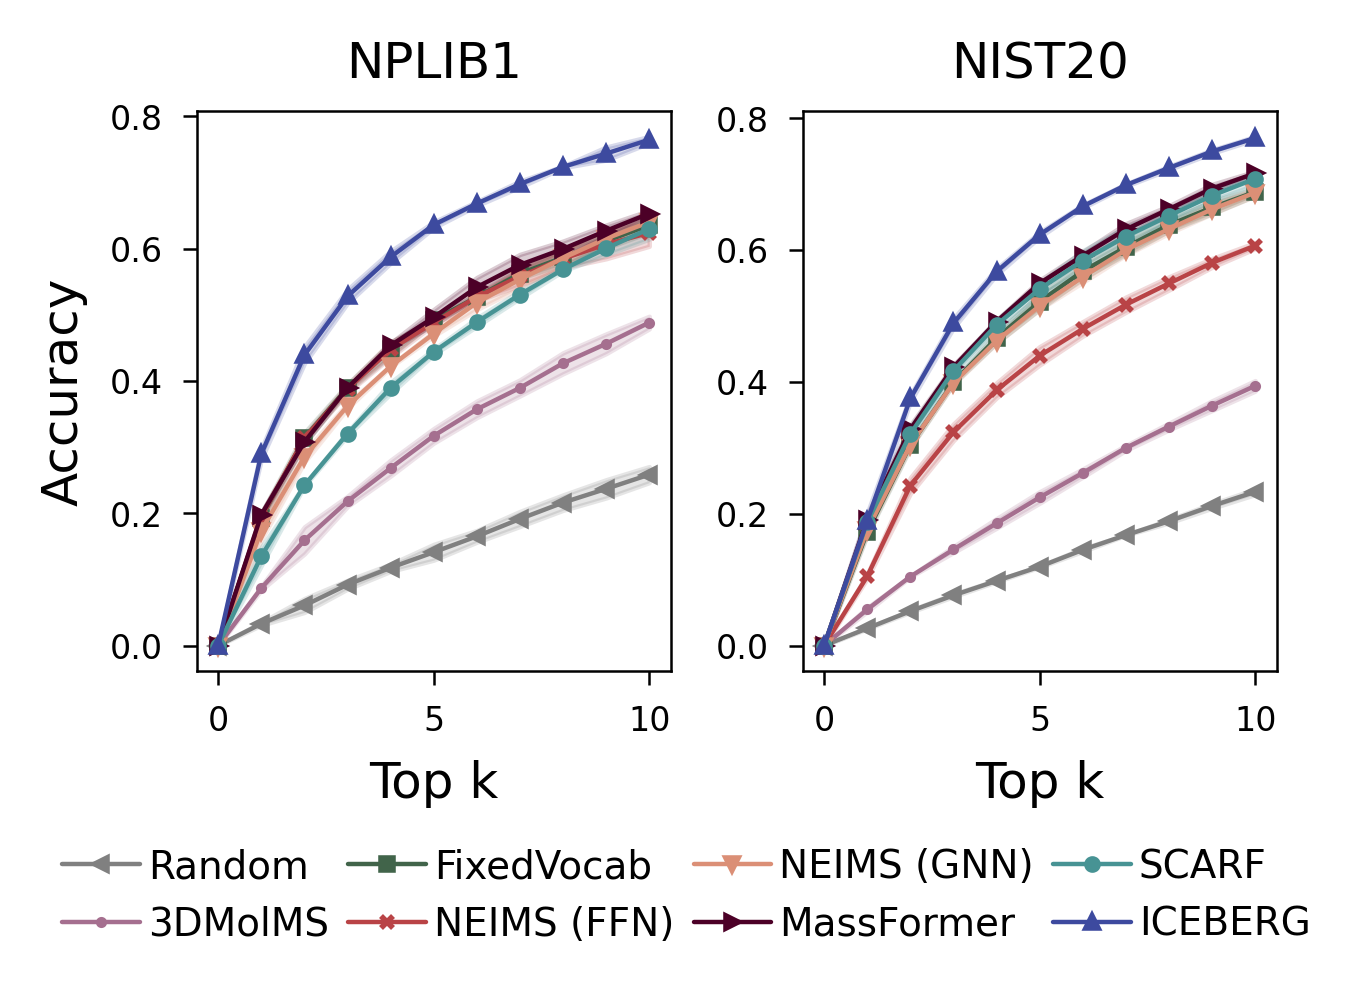

In [20]:
# Define 2 axes for fig subplot
method_names = names
figsize = (2.7, 1.4)
gridspec = dict(hspace=0.0, width_ratios=[1, 0.01, 1])
fig, axes = plt.subplots(
    1, 3, figsize=figsize, dpi=400, sharey=False, gridspec_kw=gridspec
)

axes[1].set_visible(False)
loop_ax = [axes[0], axes[2]]
for ind, (dataset_name, ax) in enumerate(
    zip(["canopus_train_public", "nist20"], loop_ax)
):
    for method in method_names:

        # Subset df by method and dataset
        sub_df = out_df[
            (out_df["Method"] == method) & (out_df["Dataset"] == dataset_name)
        ]
        topk = [0] + sub_df["Top k"].values.tolist()
        accs = [0] + sub_df["Acc mean"].values.tolist()
        error = [0] + sub_df["Acc 95%"].values.tolist()
        # ax.step(topk, accs, color=method_colors[method],
        #         linewidth=0.8, where="pre"
        # )
        marker = method_markers[method]
        ax.plot(
            topk,
            accs,
            color=method_colors[method],
            linewidth=0.8,
            label=method,
            marker=marker,
            markersize=2,
        )

        ax.fill_between(
            topk,
            np.array(accs) - np.array(error),
            np.array(accs) + np.array(error),
            alpha=0.2,
            color=method_colors[method],
        )
        # set title
        ax.set_title(plt_dataset_names[dataset_name])

    ax.set_xlabel("Top k")
    if ind == 0:
        ax.set_ylabel("Accuracy")
    # ax.set_xlim([-0.1,5.1])
    # ax.set_ylim([0, 0.3])
    if ind == 0:
        # ax.legend(frameon=False, facecolor="none",
        #           fancybox=False,loc=(1.0, 0.2), fontsize=7) #(0.99, 0.5))
        # Add legend to below both subplots and with 4 columns
        # Legend with less space between columns

        ax.legend(
            frameon=False,
            facecolor="none",
            fancybox=False,
            loc=(-0.3, -0.5),
            fontsize=7,
            ncol=4,
            columnspacing=0.5,
            handletextpad=0.2,
            borderpad=0.2,
        )

    # ax.set_ylim([0, 1.0])
set_size(*figsize, ax)
fig.savefig(
    results_folder / f"step_plot.pdf", dpi=400, bbox_inches="tight", transparent=True
)

In [6]:
## Diff calculations
def percent_improve(x,y):
    print("Percent improved: ", (x-y)/y * 100)
    print("Diff improved: ", (x-y))

percent_improve(0.627, 0.568)

Percent improved:  10.38732394366198
Diff improved:  0.05900000000000005


In [7]:
percent_improve(0.290, 0.198)

Percent improved:  46.46464646464645
Diff improved:  0.09199999999999997


In [8]:
percent_improve(0.770, 0.716)

Percent improved:  7.54189944134079
Diff improved:  0.05400000000000005


In [9]:
percent_improve(0.699, 0.682)
percent_improve(0.699, 0.669)

Percent improved:  2.4926686217008656
Diff improved:  0.016999999999999904
Percent improved:  4.484304932735413
Diff improved:  0.029999999999999916
